<a href="https://colab.research.google.com/github/Tzutzu13/Final_Project2020/blob/master/AutoEncoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing neccessary libraries**


In [ ]:
cd /content/drive/Shared drives/USV RECORDINGS/

/content/drive/Shared drives/USV RECORDINGS


In [ ]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sn
from pathlib import Path
import xlrd
from scipy import signal
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from __future__ import print_function
from keras import backend as K
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D,Input,LeakyReLU,MaxPooling2D,Dropout,Lambda,add,Activation,Concatenate,Dense,Flatten,Conv2D
from keras.utils import plot_model
from keras.models import Model
# from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import seaborn as sns
def set_callbacks( name = 'best_model_weights',patience=8,tb_base_logdir='./logs/'):
    from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
    cp = ModelCheckpoint(name +'.h5',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)
    return [rlop, es, cp]
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,5),filename = None):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,annot_kws={"size": 20})
    if filename is not None:
      plt.savefig(filename)
def Remove_None_Data_and_lowering_Labels(data,labels):
    data = [j for i,j in enumerate(data) if j is not None] 
    labels= [j for i,j in enumerate(labels) if j is not None] 
    labels = [str(i) for i in labels]
    labels = [i.lower() for i in labels]
    return data, labels
def build_model(num_classes = 2):
    inp = Input(shape=(img_rows, img_cols,1))
    x = Conv2D(32, (3, 3), padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax')(x)
    return Model(inputs=inp, outputs=x)
def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name.lower()
    Syllables = Data[ind]
    return Syllables
def print_loss(hist):
    plt.figure()
    plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.legend(['loss','val_loss'])
    plt.figure()
    plt.plot(hist.history['accuracy'], 'r', hist.history['val_accuracy'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend(['accuracy','val_accuracy'])
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i in range(nrow*ncol):
        if preds is not None and i >= len(preds):
          continue
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        # ax[i//ncol,i%ncol].pcolormesh((X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if prob is None:
            ax[i//ncol,i%ncol].set_title([i])
        else:
            ax[i//ncol,i%ncol].set_title('im ' + str(i) +', prob = ' + str(round(prob[i][preds[i]],3)))
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='yellow' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    # plt.show()
    fig.suptitle(title,fontweight="bold", size=20)


# **Define relevant functions**

In [ ]:
def shift_image(image, dx, dy,width = 28 , height = 28):
    image = image.reshape((width, height))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image

def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name.lower()
    Syllables = Data[ind]
    return Syllables
def PCA_function(Signal1,Signal2, title = 'PCA'):
 # the function gets 2 signals and performs 2 components PCA on them and plotting    
    pca = PCA(n_components=2)
    c = np.concatenate((Signal1,Signal2))
    if len(c.shape) != 2:
        c = c.reshape(c.shape[0], c.shape[1]**2)
    projected = pca.fit_transform(c)
    Label0 = np.zeros(len(Signal1))
    Label1 = np.ones(len(Signal2))
    Labels = np.concatenate((Label0,Label1))
    pca_data = np.vstack((projected.T, Labels)).T
    pca_df = pd.DataFrame(data=pca_data, columns=('1st_principal', '2nd_principal', 'label'))
    sn.FacetGrid(pca_df, hue='label', size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.title(title)
def print_loss(hist):
    plt.figure()
    plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.legend(['loss','val_loss'])

# **Mnist Autoencoder for 2000 samples**

In [ ]:
# (x_train, _), (x_test, _) = mnist.load_data()
# x_train = (x_train.astype('float32') / 255.)[0:2000]
# x_test = (x_test.astype('float32') / 255.)[0:500]
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print (x_train.shape)
# print (x_test.shape)

# encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# #autoencoder dense model - we didn't use eventually

# input_img = Input(shape=(784,))
# encoded = Dense(500, activation='relu')(input_img)
# encoded = Dense(500, activation='relu')(encoded)
# encoded = Dense(2000, activation='relu')(encoded)

# encoded = Dense(32, activation='relu')(encoded)

# decoded = Dense(2000, activation='relu')(encoded)
# decoded = Dense(500, activation='relu')(decoded)
# decoded = Dense(500, activation='relu')(decoded)

# decoded = Dense(784, activation='sigmoid')(decoded)
# # Let's try this:

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')
 
# encoder = Model(input_img, encoded)


# history = autoencoder.fit(x_train, x_train,
#                 epochs=100,
#                 batch_size=256,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

# encoded_imgs = encoder.predict(x_train)
# decoded_imgs = autoencoder.predict(x_train)

In [ ]:
# encoder.summary()
# autoencoder.summary()

In [ ]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

(x_train, _), (x_test, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.)[0:2000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

11493376/11490434 [==============================] - 1s 0us/step
(2000, 784)
(500, 784)
Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 2s 829us/step - loss: 0.2263 - val_loss: 0.2155
Epoch 2/100
2000/2000 [==============================] - 0s 15us/step - loss: 0.1953 - val_loss: 0.1658
Epoch 3/100
2000/2000 [==============================] - 0s 15us/step - loss: 0.1363 - val_loss: 0.1074
Epoch 4/100
2000/2000 [==============================] - 0s 15us/step - loss: 0.0916 - val_loss: 0.0800
Epoch 5/100
2000/2000 [==============================] - 0s 14us/step - loss: 0.0756 - val_loss: 0.0725
Epoch 6/100
2000/2000 [==============================] - 0s 14us/step - loss: 0.0714 - val_loss: 0.0700
Epoch 7/100
2000/2000 [==============================] - 0s 19us/step - loss: 0.0696 - val_loss: 0.0685
Epoch 8/100
2000/2000 [==============================] - 0s 14us/step - loss: 0.0685 - val_loss: 0.0675
Epoch 9/100
2000/2000 [=========

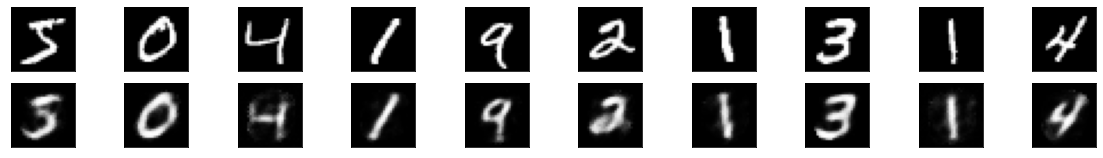

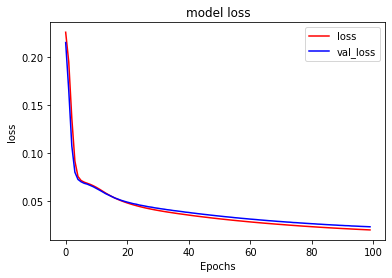

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
print_loss(history)



# **Mnist Autoencoder for 10000 samples**

In [ ]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

(x_train, _), (x_test, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.)[0:10000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(10000, 784)
(500, 784)
Train on 10000 samples, validate on 500 samples
Epoch 1/50
10000/10000 [==============================] - 0s 18us/step - loss: 0.1420 - val_loss: 0.0722
Epoch 2/50
10000/10000 [==============================] - 0s 14us/step - loss: 0.0690 - val_loss: 0.0632
Epoch 3/50
10000/10000 [==============================] - 0s 12us/step - loss: 0.0595 - val_loss: 0.0544
Epoch 4/50
10000/10000 [==============================] - 0s 14us/step - loss: 0.0513 - val_loss: 0.0488
Epoch 5/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0462 - val_loss: 0.0452
Epoch 6/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0428 - val_loss: 0.0423
Epoch 7/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0400 - val_loss: 0.0398
Epoch 8/50
10000/10000 [==============================] - 0s 12us/step - loss: 0.0377 - val_loss: 0.0379
Epoch 9/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0356 - 

Text(0.5, 0, 'epoch')

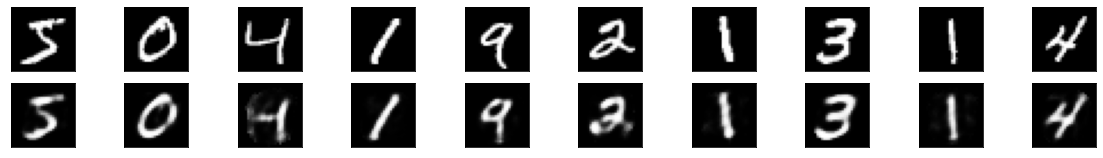

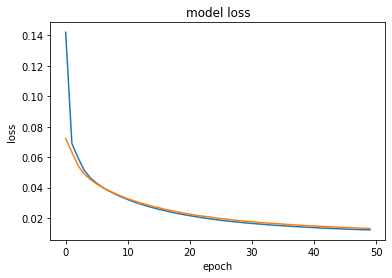

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')


# **Mnist Autoencoder augment to 10000 samples**

In [ ]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')


# augment to 10000


# # Creating Augmented Dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.)[0:2000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train_augmented = [image for image in x_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
      for image in zip(x_train):
              x_train_augmented.append(shift_image(image[0], dx, dy))
x_train = np.asarray(x_train_augmented)
# x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(10000, 784)
(500, 784)
Train on 10000 samples, validate on 500 samples
Epoch 1/50
10000/10000 [==============================] - 0s 18us/step - loss: 0.1462 - val_loss: 0.0729
Epoch 2/50
10000/10000 [==============================] - 0s 14us/step - loss: 0.0706 - val_loss: 0.0657
Epoch 3/50
10000/10000 [==============================] - 0s 14us/step - loss: 0.0629 - val_loss: 0.0564
Epoch 4/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0540 - val_loss: 0.0496
Epoch 5/50
10000/10000 [==============================] - 0s 14us/step - loss: 0.0482 - val_loss: 0.0453
Epoch 6/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0443 - val_loss: 0.0423
Epoch 7/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0414 - val_loss: 0.0397
Epoch 8/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0389 - val_loss: 0.0378
Epoch 9/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0368 - 

Text(0.5, 0, 'epoch')

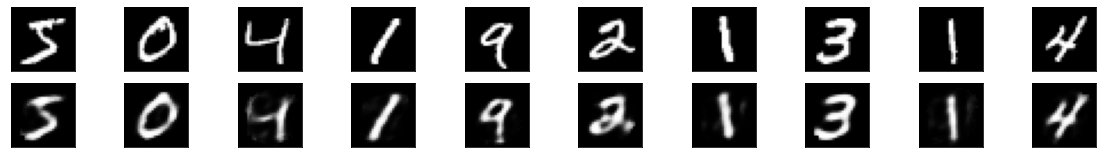

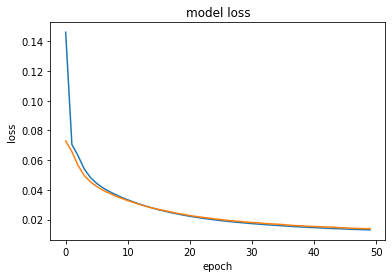

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# **Mnist Autoencoder for 2 categories - 6 & 3 , showing PCA**
Augmentation also 

In [ ]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')
(x_train, y_train), (x_test, y_test) = mnist.load_data()
ind = (y_train == 6) | (y_train == 3)
ind_test =  (y_test == 6) | (y_test== 3)
x_train = x_train[ind]
y_train = y_train[ind]
x_test = x_test[ind_test]
y_test = y_test[ind_test]
# value, counts = np.unique(y_test,return_counts = True)
x_train = (x_train.astype('float32') / 255.)[0:1000]
y_train = y_train[0:1000]

x_test = (x_test.astype('float32') / 255.)[0:500]
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(1000, 784)
(500, 784)
Train on 1000 samples, validate on 500 samples
Epoch 1/100
1000/1000 [==============================] - 0s 79us/step - loss: 0.2279 - val_loss: 0.2236
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 0.2178 - val_loss: 0.2081
Epoch 3/100
1000/1000 [==============================] - 0s 18us/step - loss: 0.1974 - val_loss: 0.1819
Epoch 4/100
1000/1000 [==============================] - 0s 25us/step - loss: 0.1671 - val_loss: 0.1487
Epoch 5/100
1000/1000 [==============================] - 0s 17us/step - loss: 0.1330 - val_loss: 0.1164
Epoch 6/100
1000/1000 [==============================] - 0s 19us/step - loss: 0.1039 - val_loss: 0.0923
Epoch 7/100
1000/1000 [==============================] - 0s 18us/step - loss: 0.0848 - val_loss: 0.0784
Epoch 8/100
1000/1000 [==============================] - 0s 22us/step - loss: 0.0748 - val_loss: 0.0716
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 0.0700 - val_loss: 0

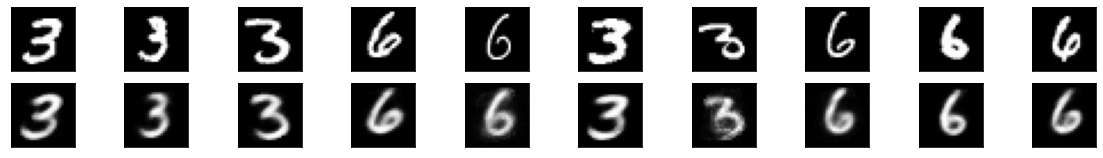

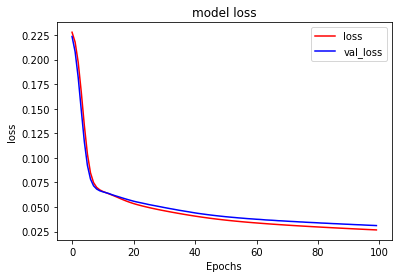

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
print_loss(history)



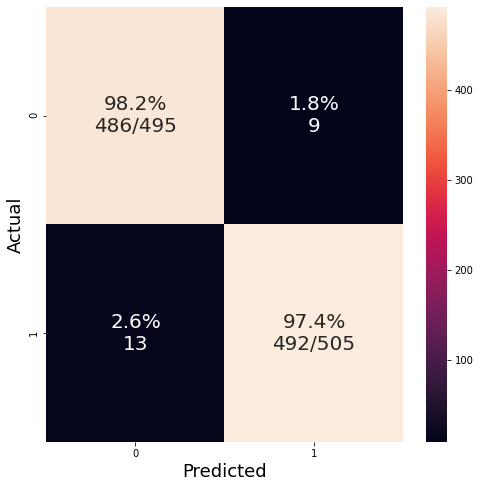

In [ ]:
from sklearn.cluster import KMeans

np.random.seed(10)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
y_train[y_train == 3] = 0
y_train[y_train == 6] = 1

y_pred = kmeans.fit_predict(encoder.predict(x_train))
cm_analysis(y_train,y_pred, np.arange(2),figsize=(8,8))


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


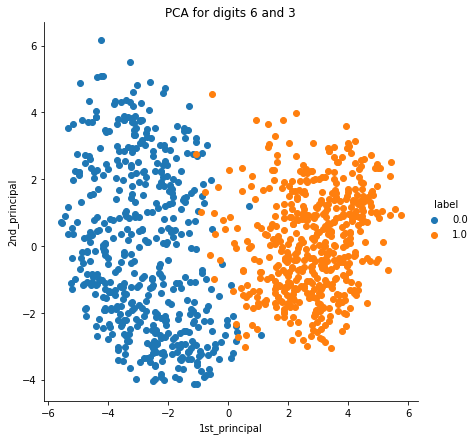

In [ ]:
# PCA for two categories
(x_train, y_train), (x_test, y_test) = mnist.load_data()
ind = (y_train == 6)
ind1 = (y_train == 3)
ind_test =  (y_test == 6) | (y_test== 3)
x_train0 = (x_train[ind].astype('float32') / 255.)[0:500].reshape(500, 28*28)
x_train1 = (x_train[ind1].astype('float32') / 255.)[0:500].reshape(500, 28*28)
PCA_function(x_train0,x_train1, 'PCA for digits 6 and 3')  

In [ ]:
# augment to 5000
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

# # Creating Augmented Dataset
(X_train, y_train), (x_test, y_test) = mnist.load_data()
ind = (y_train == 6) | (y_train == 3)
ind_test =  (y_test == 6) | (y_test== 3)
X_train = X_train[ind]
y_train = y_train[ind]
x_test = x_test[ind_test]
y_test = y_test[ind_test]
X_train = (X_train.astype('float32') / 255.)[0:1000]
y_train = y_train[0:1000]
x_test = (x_test.astype('float32') / 255.)[0:500]
X_train_augmented = [image for image in X_train]
y_train_augmented = [image for image in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image, label in zip(X_train, y_train):
             X_train_augmented.append(shift_image(image, dx, dy))
             y_train_augmented.append(label)

X_train = np.asarray(X_train_augmented)
# x_train = x_train.astype('float32')
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (X_train.shape)
print (x_test.shape)

history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(X_train)
decoded_imgs = decoder.predict(encoded_imgs)

(5000, 784)
(500, 784)
Train on 5000 samples, validate on 500 samples
Epoch 1/100
5000/5000 [==============================] - 0s 26us/step - loss: 0.1962 - val_loss: 0.1269
Epoch 2/100
5000/5000 [==============================] - 0s 15us/step - loss: 0.0869 - val_loss: 0.0675
Epoch 3/100
5000/5000 [==============================] - 0s 14us/step - loss: 0.0678 - val_loss: 0.0631
Epoch 4/100
5000/5000 [==============================] - 0s 15us/step - loss: 0.0631 - val_loss: 0.0589
Epoch 5/100
5000/5000 [==============================] - 0s 13us/step - loss: 0.0584 - val_loss: 0.0549
Epoch 6/100
5000/5000 [==============================] - 0s 13us/step - loss: 0.0545 - val_loss: 0.0520
Epoch 7/100
5000/5000 [==============================] - 0s 13us/step - loss: 0.0511 - val_loss: 0.0488
Epoch 8/100
5000/5000 [==============================] - 0s 14us/step - loss: 0.0480 - val_loss: 0.0461
Epoch 9/100
5000/5000 [==============================] - 0s 14us/step - loss: 0.0452 - val_loss: 0

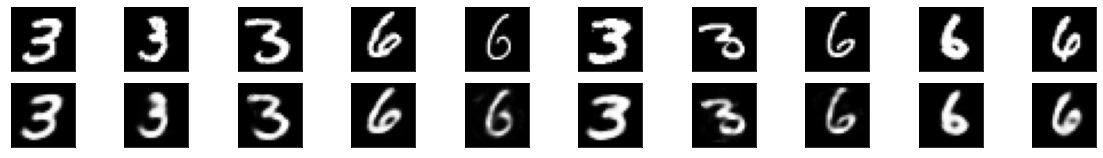

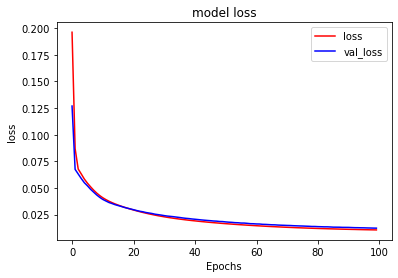

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
print_loss(history)



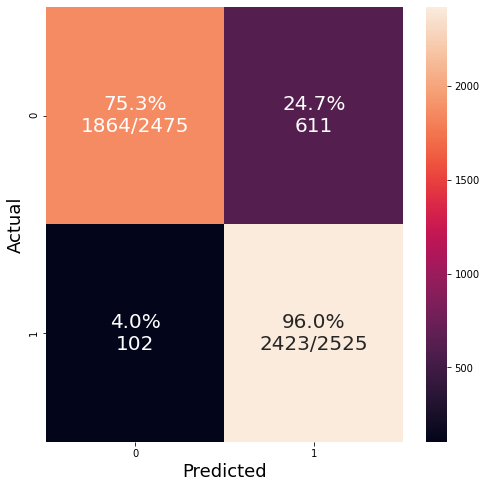

In [ ]:
from sklearn.cluster import KMeans

np.random.seed(10)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
y_train_augmented = np.array(y_train_augmented)
y_train_augmented[y_train_augmented == 3] = 0
y_train_augmented[y_train_augmented == 6] = 1
y_pred = kmeans.fit_predict(encoder.predict(X_train))
cm_analysis(y_train_augmented,y_pred, np.arange(2),figsize=(8,8))



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


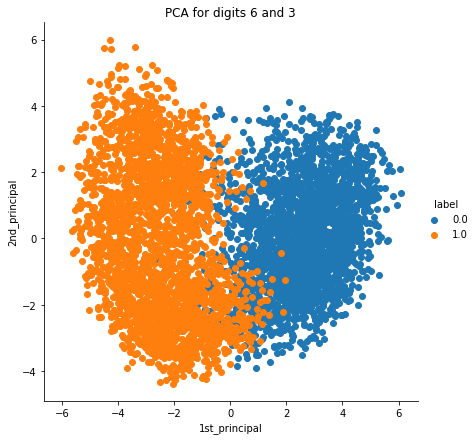

In [ ]:
# PCA for augmented two categories

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

ind = (y_train_augmented == 0)
ind1 = (y_train_augmented == 1)
# ind_test =  (y_test == 6) | (y_test== 3)
x_train0 = X_train[ind].reshape(len(X_train[ind]), 28*28)
x_train1 = X_train[ind1].reshape(len(X_train[ind1]), 28*28)
PCA_function(x_train0,x_train1, 'PCA for digits 6 and 3')  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'upward and complex PCA for 200 samples')

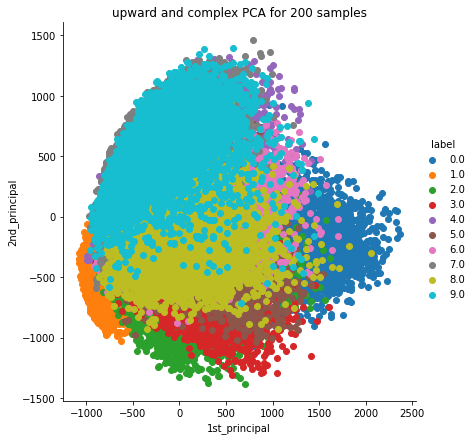

In [ ]:
# PCA on all the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
pca = PCA(n_components=2)
c = x_train.reshape(60000,28*28)
# c = c.reshape(c.shape[:-1])
projected = pca.fit_transform(c)
Labels = y_train
import pandas as pd
import seaborn as sn
pca_data = np.vstack((projected.T, Labels)).T
pca_df = pd.DataFrame(data=pca_data, columns=('1st_principal', '2nd_principal', 'label'))
sn.FacetGrid(pca_df, hue='label', size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.title('upward and complex PCA for 200 samples')

# **Checking PCA for 2 different signals**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


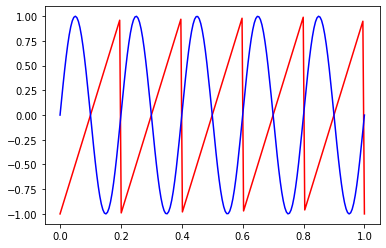

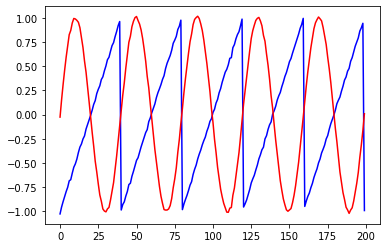

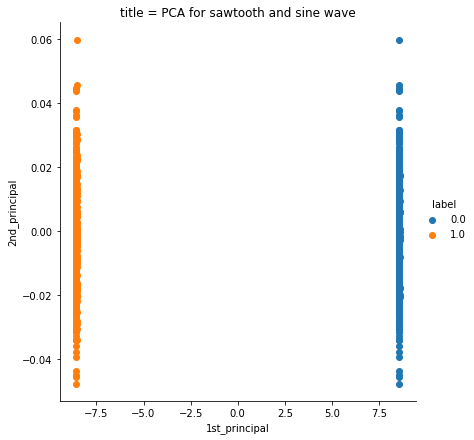

In [ ]:
t = np.linspace(0, 1, 200)
saw_tooth = signal.sawtooth(2 * np.pi * 5 * t)
sine = np.sin(2 * np.pi * 5 * t)
plt.figure()
plt.plot(t, saw_tooth,'r', t, sine,'b')
L0 = np.zeros(500)
L1 = np.ones(500)
Labels = np.concatenate((L0,L1))
noise = np.random.normal(0,1,(500,len(t)))*0.01
sine = np.zeros((500,len(t)))
sine[:] = np.sin(2 * np.pi * 5 * t)
sine = sine + noise
saw_tooth = np.zeros((500,len(t)))
saw_tooth[:] = signal.sawtooth(2 * np.pi * 5 * t)
saw_tooth = saw_tooth + noise
plt.figure()
plt.plot(saw_tooth[0],'b')
plt.plot(sine[0],'r')

PCA_function(saw_tooth,sine,'title = PCA for sawtooth and sine wave')  

# **USV Autoencoder for 2 categories , showing PCA**

In [ ]:
img_rows, img_cols = 64, 64 #choosing resize values
Data_united = np.load('Data_united.npy',allow_pickle = True)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data_united = np.array([scaler.fit_transform(i) for i in Data_united])

Labels_united = np.load('Labels_united.npy',allow_pickle = True)

Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('upward',Data_united,Labels_united)
flat_syl = Take_Syllables('flat',Data_united,Labels_united)
short_syl = Take_Syllables('short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('downward',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
Chevron_Labels = 2*np.ones((len(Chevron_syl)))
composite_Labels = 3*np.ones((len(Composite_syl)))
Noise_Labels = 4*np.ones((len(Noise_syl)))
two_syllable_Labels = 5*np.ones((len(two_syllable_syl)))
upward_Labels = 6*np.ones((len(upward_syl)))
flat_Labels = 7*np.ones((len(flat_syl)))
short_Labels = 8*np.ones((len(short_syl)))
harmonics_Labels = 9*np.ones((len(harmonics_syl)))
downward_Labels = 10*np.ones((len(downward_syl)))

In [ ]:
labels, levels = pd.factorize(Labels_united)

In [ ]:
x = Data_united
x = np.expand_dims(x,axis = -1)   
y = labels
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl[0:len(Complex_syl)]))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels[0:len(complex_Labels)]))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15

In [ ]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(4096,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(4096, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
autoencoder.compile(optimizer='adam', loss='mse')

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_train)
decoded_imgs = decoder.predict(encoded_imgs)



Train on 1368 samples, validate on 242 samples
Epoch 1/100
1368/1368 [==============================] - 0s 90us/step - loss: 0.2278 - val_loss: 0.2121
Epoch 2/100
1368/1368 [==============================] - 0s 33us/step - loss: 0.1910 - val_loss: 0.1434
Epoch 3/100
1368/1368 [==============================] - 0s 33us/step - loss: 0.1127 - val_loss: 0.0675
Epoch 4/100
1368/1368 [==============================] - 0s 31us/step - loss: 0.0502 - val_loss: 0.0348
Epoch 5/100
1368/1368 [==============================] - 0s 30us/step - loss: 0.0292 - val_loss: 0.0281
Epoch 6/100
1368/1368 [==============================] - 0s 32us/step - loss: 0.0255 - val_loss: 0.0270
Epoch 7/100
1368/1368 [==============================] - 0s 30us/step - loss: 0.0248 - val_loss: 0.0267
Epoch 8/100
1368/1368 [==============================] - 0s 30us/step - loss: 0.0245 - val_loss: 0.0266
Epoch 9/100
1368/1368 [==============================] - 0s 31us/step - loss: 0.0244 - val_loss: 0.0264
Epoch 10/100
1368

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


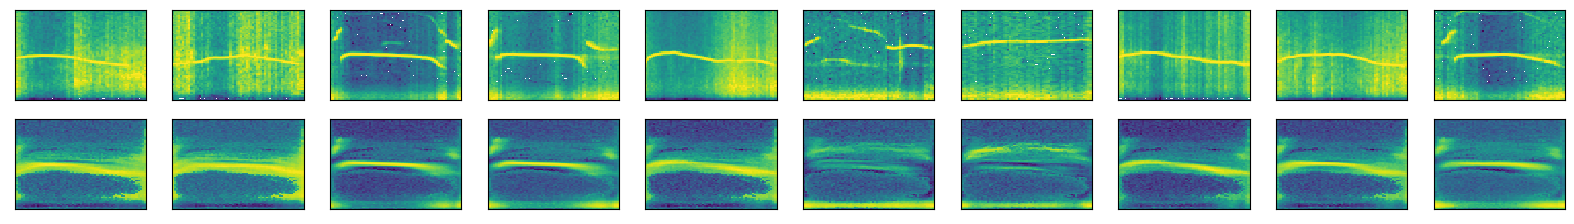

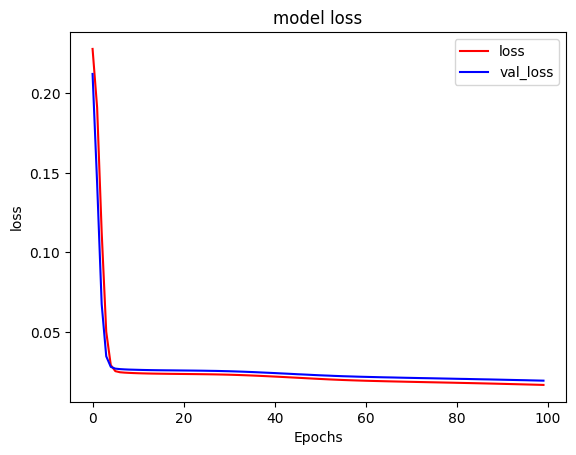

In [ ]:
plt.style.use('default')
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+100]).reshape(64, 64))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+100]).reshape(64, 64))
    plt.xticks([])
    plt.yticks([])


print_loss(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


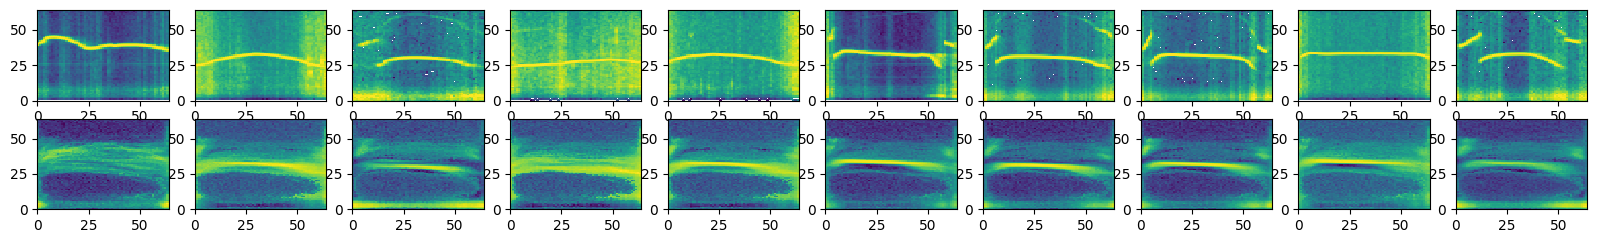

In [ ]:
plt.style.use('default')
n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    # display original
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+200]).reshape(64, 64))

    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+200]).reshape(64, 64))



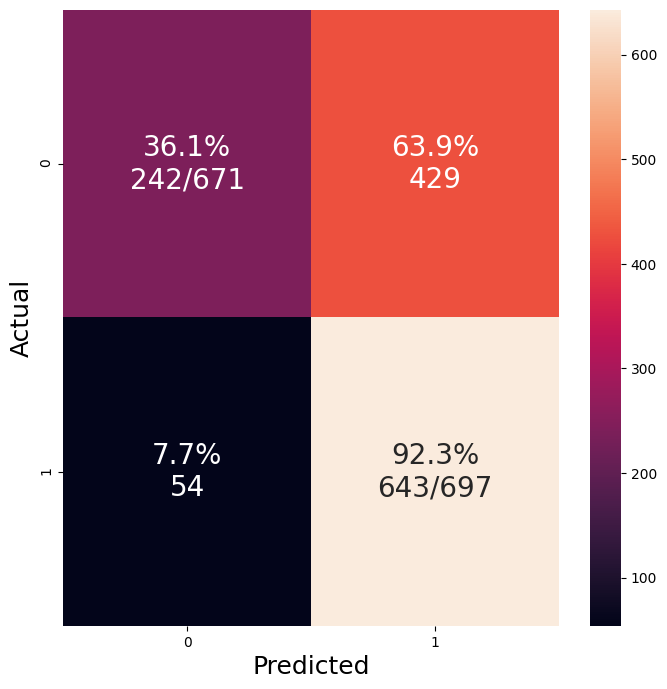

In [ ]:
from sklearn.cluster import KMeans

np.random.seed(10)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
y_pred = kmeans.fit_predict(encoder.predict(X_train))
cm_analysis(y_train,y_pred, np.arange(2),figsize=(8,8))


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


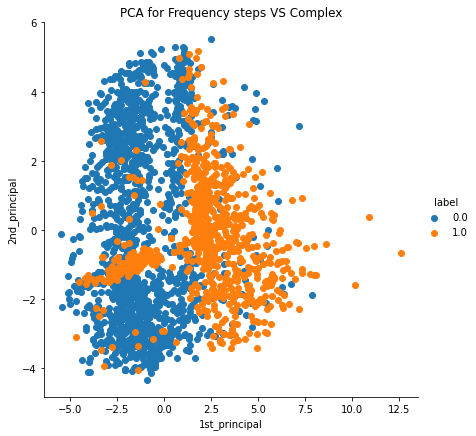

In [ ]:
PCA_function(Frequency_steps_syl,Complex_syl, title = 'PCA for Frequency steps VS Complex')  

# **USV Autoencoder for 2 categories with augmentation , showing PCA**

In [ ]:
img_rows, img_cols = 64, 64 #choosing resize values
Data_united = np.load('Data_united.npy',allow_pickle = True)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data_united = np.array([scaler.fit_transform(i) for i in Data_united])

Labels_united = np.load('Labels_united.npy',allow_pickle = True)

Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('upward',Data_united,Labels_united)
flat_syl = Take_Syllables('flat',Data_united,Labels_united)
short_syl = Take_Syllables('short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('downward',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

In [ ]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)


In [ ]:
#Augmentation
X_train = X_train.reshape(X_train.shape[:-1])
X_train_augmented = [image for image in X_train[:-1]]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image in zip(X_train):
             X_train_augmented.append(shift_image(image[0], dx, dy,64,64))

X_train = np.asarray(X_train_augmented)


In [ ]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(4096,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(4096, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_train)
decoded_imgs = decoder.predict(encoded_imgs)

Train on 9629 samples, validate on 341 samples
Epoch 1/100
9629/9629 [==============================] - 0s 33us/step - loss: 0.1062 - val_loss: 0.0239
Epoch 2/100
9629/9629 [==============================] - 0s 25us/step - loss: 0.0233 - val_loss: 0.0228
Epoch 3/100
9629/9629 [==============================] - 0s 25us/step - loss: 0.0226 - val_loss: 0.0220
Epoch 4/100
9629/9629 [==============================] - 0s 25us/step - loss: 0.0219 - val_loss: 0.0214
Epoch 5/100
9629/9629 [==============================] - 0s 24us/step - loss: 0.0215 - val_loss: 0.0210
Epoch 6/100
9629/9629 [==============================] - 0s 24us/step - loss: 0.0210 - val_loss: 0.0205
Epoch 7/100
9629/9629 [==============================] - 0s 25us/step - loss: 0.0203 - val_loss: 0.0197
Epoch 8/100
9629/9629 [==============================] - 0s 25us/step - loss: 0.0196 - val_loss: 0.0190
Epoch 9/100
9629/9629 [==============================] - 0s 25us/step - loss: 0.0190 - val_loss: 0.0184
Epoch 10/100
9629

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


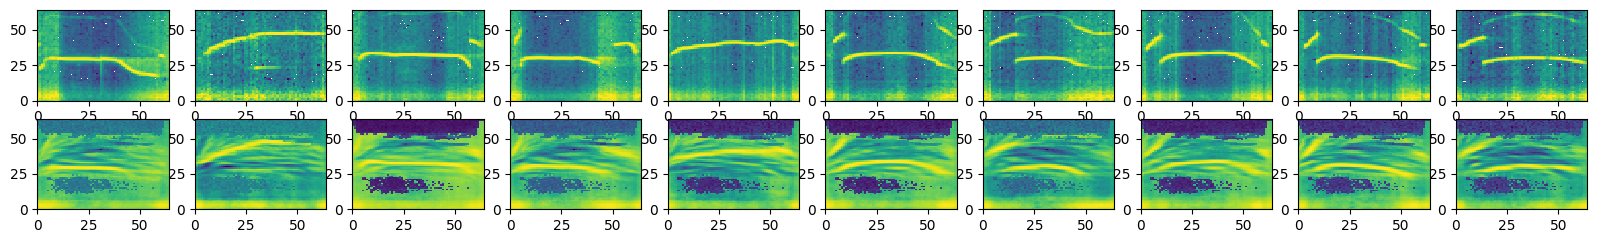

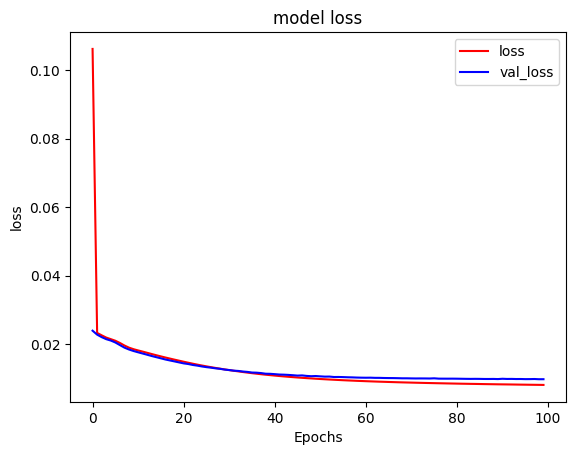

In [ ]:
plt.style.use('default')
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+100]).reshape(64, 64))
    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+100]).reshape(64, 64))
    
print_loss(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


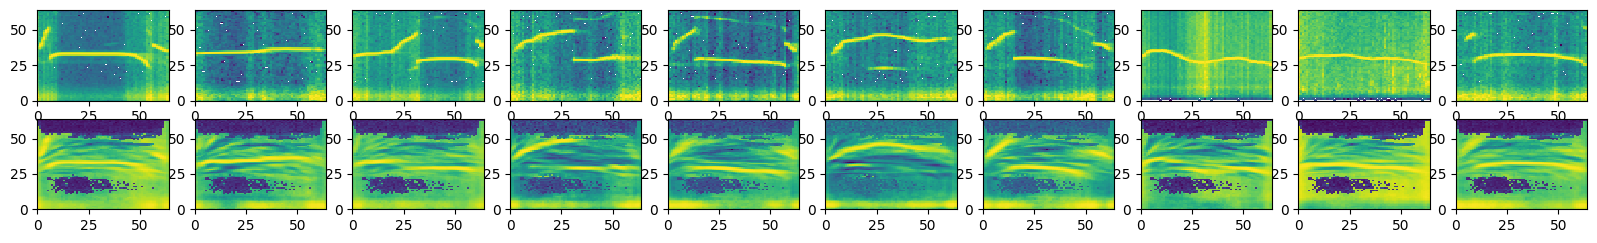

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    # display original
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+200]).reshape(64, 64))

    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+200]).reshape(64, 64))